In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = np.load("./mcs_hw2_p2_data.npy")

In [3]:
np.mean(data), np.std(data)

(1.0253894838171627, 2.0215609243050543)

In [4]:
miu_0 = 0.0
tau_0 = 1.0
gamma_0 = 1.0
sigma_0 = 1.0
n = data.size
y_mean = np.mean(data)

In [8]:
def gibbs_sampler(n):
    def sample_miu(sigma): # sigma: STD, not squared!
        mean_above = miu_0 / (tau_0 * tau_0) + n * y_mean / (sigma * sigma)
        mean_below = 1.0 / (tau_0 * tau_0) + n / (sigma * sigma)
        mean = mean_above / mean_below
        var = 1 / (1 / (tau_0 * tau_0) + n / (sigma * sigma))
        new_miu = np.random.normal(mean, var)
        return new_miu
    def sample_sigma(miu):
        chi_square = np.random.chisquare(gamma_0 + n)
        inv_chi_square = 1.0 / chi_square
        gamma = np.mean(np.square(data - miu))
        scale = (gamma_0 * sigma_0 * sigma_0 + gamma * n) / (gamma_0 + n)
        inv_scaled_chi_square = inv_chi_square * scale * (gamma_0 + n)
        return np.sqrt(inv_scaled_chi_square)
    miu = np.random.normal(miu_0, tau_0)
    sigma = np.sqrt(1.0 / np.random.chisquare(1.0))
    res_miu = []
    res_sigma = []
    for i in range(n):
        miu = sample_miu(sigma)
        sigma = sample_sigma(miu)
        res_miu.append(miu)
        res_sigma.append(sigma)
    return res_miu, res_sigma

In [9]:
gibbs_miu, gibbs_sigma = gibbs_sampler(1000)

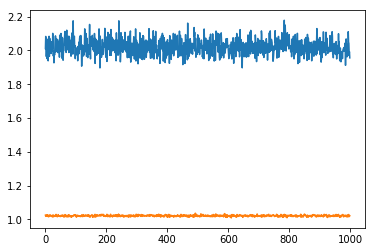

In [11]:
plt.plot(gibbs_sigma)
plt.plot(gibbs_miu)
plt.savefig("gibbs")

In [12]:
def get_log_likelihood(data, miu, sigma):
    # up to a normalizing constant
    res_miu = - (miu - miu_0) * (miu - miu_0)
    res_sigma = - gamma_0 * sigma_0 * sigma_0 / (2 * sigma * sigma) - (2 + gamma_0) * np.log(sigma)
    res_data = 0
    for y in data:
        res_data += -np.log(sigma) - (y - miu) * (y - miu) / (2 * sigma * sigma)
    return res_miu + res_sigma + res_data

In [34]:
def metropolis_sampler(n, step_mu, step_sigma):
    def sample_miu(miu):
        mean = miu
        var = 1.
        new_miu = np.random.normal(mean, step_mu)
        return new_miu
    def sample_sigma(sigma):
        rand = np.random.uniform(-step_sigma, step_sigma)
        new_sigma_2 = np.exp(rand) * sigma * sigma
        return np.sqrt(new_sigma_2)
    miu = np.random.normal(miu_0, tau_0)
    sigma = np.sqrt(1.0 / np.random.chisquare(1.0))
    res_miu = []
    res_sigma = []
    for i in range(n):
        new_miu = sample_miu(miu)
        new_sigma = sample_sigma(sigma)
        prob = np.exp(get_log_likelihood(data, new_miu, new_sigma) - get_log_likelihood(data, miu, sigma))
        prob = min(prob, 1.0)
        if np.random.binomial(1, prob) == 1:
            miu = new_miu
            sigma = new_sigma
        res_miu.append(miu)
        res_sigma.append(sigma)
    return res_miu, res_sigma

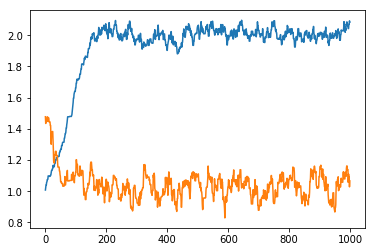

In [35]:
metropolis_miu, metropolis_sigma = metropolis_sampler(1000, .04, .04)
plt.plot(metropolis_sigma)
plt.plot(metropolis_miu)
plt.savefig("metropolis")

Text(0.5,1,'traceplot of mu')

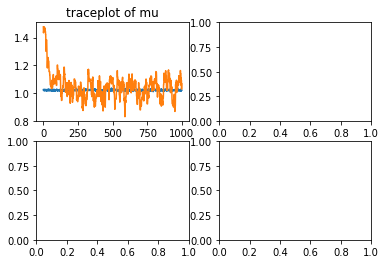

In [65]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(gibbs_miu)
axs[0, 0].plot(metropolis_miu)
axs[0, 0].set_title("traceplot of mu")

In [66]:
axs[0, 1].plot(gibbs_sigma)
axs[0, 1].plot(metropolis_sigma)
axs[0, 1].set_title("traceplot of sigma")

Text(0.5,1,'traceplot of sigma')

In [67]:
def autocorr(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)


In [68]:
axs[1, 0].plot(autocorr(gibbs_miu[200:], range(800)))
axs[1, 0].plot(autocorr(metropolis_miu[200:], range(800)))
axs[1, 0].set_title("ACF of mu")

Text(0.5,1,'ACF of mu')

In [69]:
axs[1, 1].plot(autocorr(gibbs_sigma[200:], range(800)))
axs[1, 1].plot(autocorr(metropolis_sigma[200:], range(800)))
axs[1, 1].set_title("ACF of sigma")

Text(0.5,1,'ACF of sigma')

In [70]:
for ax in axs.flat:
    ax.label_outer()
    ax.get_yaxis().set_ticks([])

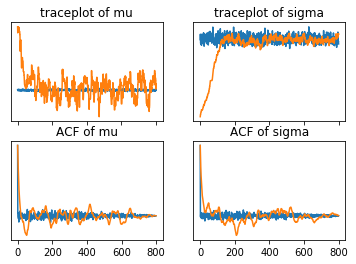

In [71]:
fig

In [72]:
fig.savefig("analysis")